In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [19]:
from datetime import timedelta, datetime

The latest date is: 2017-08-23
Date 1 year ago: 2016-08-23
            Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.02
2016-08-23           0.05
2016-08-23           0.70
2016-08-23           0.15
...                   ...
2017-08-22           0.50
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.45

[2021 rows x 1 columns]


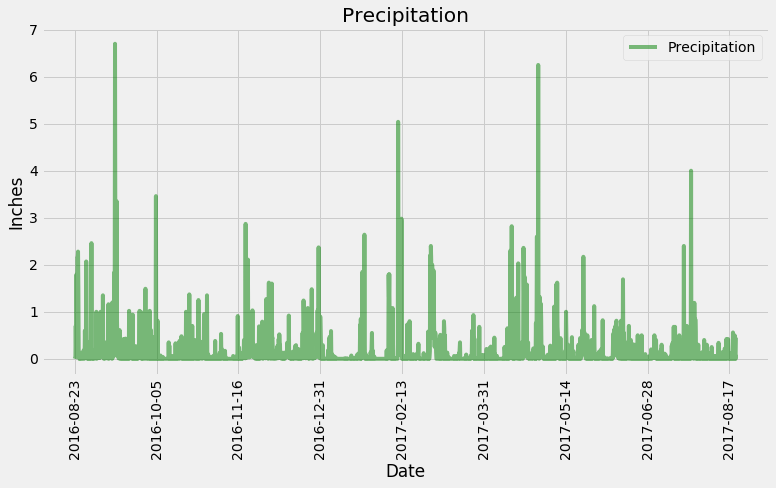

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The latest date is: {latest_date[0]}")

year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"Date 1 year ago: {year_ago}")

# Perform a query to retrieve the data and precipitation scores
scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df = pd.DataFrame(scores, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how='any')
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
print(precipitation_df)

precipitation_df.plot(figsize=(11,7),color='g',alpha=0.5)
plt.title("Precipitation")
plt.ylabel('Inches')
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [32]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count[0][0]

9

In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

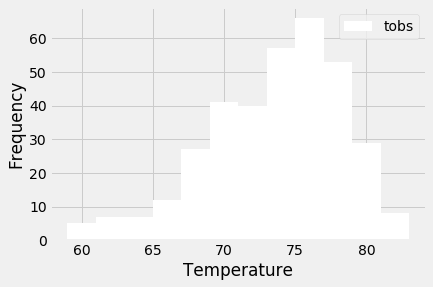

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_station = session.query(Measurement.date, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date >= year_ago).all()

highest_df = pd.DataFrame(highest_station)


highest_df.plot(kind="hist",bins=12, color = 'w')
plt.xlabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [39]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2016-03-20','2016-03-30')
print(trip )

[(62.0, 71.23188405797102, 82.0)]


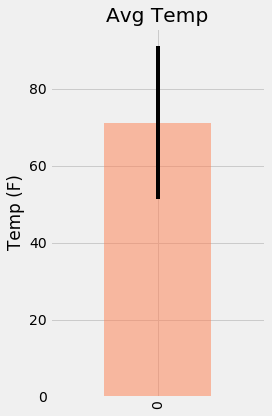

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=["Min Temp","Avg Temp","Max Temp"])

trip_df.plot.bar(y='Avg Temp', yerr=(trip_df['Max Temp'] - trip_df['Min Temp']),color='coral', alpha=0.5, figsize=(4,6), title='Avg Temp')

#plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()

plt.show()

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date_prev = '2016-03-20'
end_date_prev = '2016-03-30'

rainfall = session.query(Station.station,  Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date_prev).\
    filter(Measurement.date <= end_date_prev).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_df = pd.DataFrame(rainfall, columns=["Station","Name","Latitude","Longitude","Elevation","Prcp Sum"])
rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Prcp Sum
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.67
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.15
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.99
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.78
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.25
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.21
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [50]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [51]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-03-20'
end_date = '2016-03-30'

# Use the start and end date to create a range of dates
dates_lookup = session.query(Measurement.date).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).\
        group_by(Measurement.date).all()

trip_dates_range = [x[0] for x in dates_lookup]

trip_dates_stripped= [x[5:] for x in trip_dates_range]

start_m_day = trip_dates_stripped[0]
end_m_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date

daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).
                       filter(func.strftime("%m-%d", Measurement.date) >= start_m_day).
                       filter(func.strftime("%m-%d", Measurement.date) <= end_m_day).
                       group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
daily_normals

[(62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0),
 (63.0, 71.53846153846153, 80.0),
 (59.0, 71.51785714285714, 82.0),
 (58.0, 71.35714285714286, 77.0),
 (62.0, 72.17543859649123, 79.0)]

In [53]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df= pd.DataFrame(daily_normals,columns=['Min temp', 'Avg temp', 'Max temp'])

daily_normals_df['date']= trip_dates_range
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,Min temp,Avg temp,Max temp
date,,,
2016-03-20,62.0,70.117647,80.0
2016-03-21,60.0,71.076923,77.0
2016-03-22,65.0,71.754717,77.0
2016-03-23,63.0,70.796296,78.0
2016-03-24,62.0,71.500000,77.0
2016-03-25,63.0,71.500000,78.0
2016-03-26,64.0,71.380000,80.0
2016-03-27,63.0,71.538462,80.0
2016-03-28,59.0,71.517857,82.0


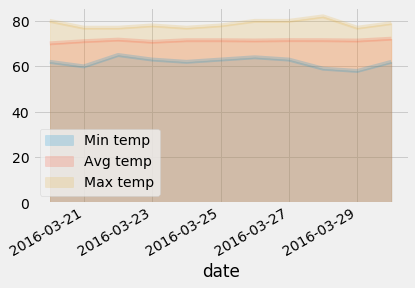

In [54]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(alpha=.2, stacked=False, x_compat=True)

